# Распознавание китайских иероглифов - классификация

Ноутбук содержит код с предобработкой данных и несколько моделей, созданных мной для решения задачи. Лучшее предсказание ( >0.98) получено с помощью модели, помеченной как " Лучшая модель"



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.enable_eager_execution()
tf.compat.v2.random.set_seed(42)

#Загружаем данные
Был использован kaggle api, так что для загрузки нужен файл kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
import kaggle
! kaggle competitions download -c chinese-char-recognition-smmo19

 91% 177M/195M [00:03<00:00, 23.2MB/s]
100% 195M/195M [00:03<00:00, 54.2MB/s]
 94% 106M/113M [00:01<00:00, 49.9MB/s] 
100% 113M/113M [00:01<00:00, 80.4MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 137MB/s]
 92% 171M/185M [00:02<00:00, 84.8MB/s]
100% 185M/185M [00:02<00:00, 85.7MB/s]
 97% 196M/202M [00:02<00:00, 71.4MB/s]
100% 202M/202M [00:02<00:00, 79.2MB/s]
 92% 153M/165M [00:02<00:00, 46.6MB/s]
100% 165M/165M [00:02<00:00, 74.1MB/s]


In [0]:
! unzip "train-1.npy.zip"
! unzip "train-2.npy.zip"
! unzip "train-3.npy.zip"
! unzip "train-4.npy.zip"
! unzip "test.npy.zip"

Archive:  train-1.npy.zip
  inflating: train-1.npy             
Archive:  train-2.npy.zip
  inflating: train-2.npy             
Archive:  train-3.npy.zip
  inflating: train-3.npy             
Archive:  train-4.npy.zip
  inflating: train-4.npy             
Archive:  test.npy.zip
  inflating: test.npy                


#Создаем датасет

PS. Код для загрузки и предобработки данных был любезно предоставлен нам семинаристом на паре - мы вместе с ним прописали нужные функции

На всякий случай сразу перемешиваем объекты

In [0]:
data_train = np.load('train-1.npy', allow_pickle=True)

for i in range(2, 5):
  t = np.load(f"./train-{i}.npy", allow_pickle=True)
  data_train = np.concatenate([data_train, t])

data_test = np.load("test.npy", allow_pickle=True)

from sklearn.utils import shuffle
data_train = shuffle(data_train)

#Немного изучим данные

Посмотрим на распределаение классов

In [0]:
labels = [label for img, label in data_train]
labels = pd.Series(labels)
labels.value_counts(ascending=True)

59831    279
63679    281
64959    282
59859    283
62134    288
        ... 
61641    378
60362    381
62163    383
64447    390
62925    400
Length: 1000, dtype: int64

In [0]:
#объектов самого распространненного класса на 121 больше, чем самого малочисленного
labels.value_counts(ascending=True).max() - labels.value_counts(ascending=True).min()

121

Как видим, распределение несколько несбалансировано

#Теперь взглянем и на сами картинки

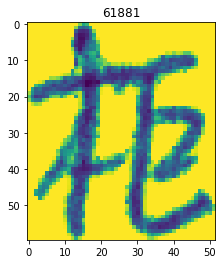

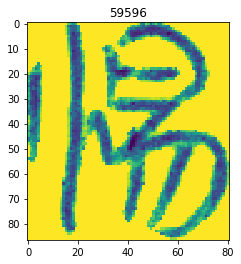

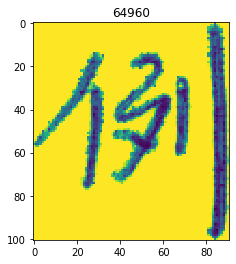

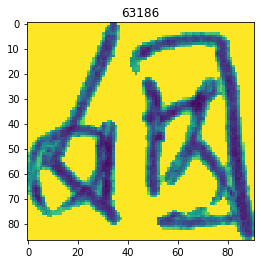

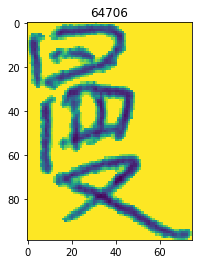

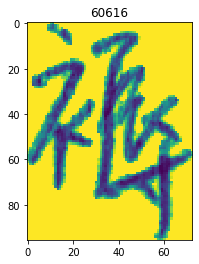

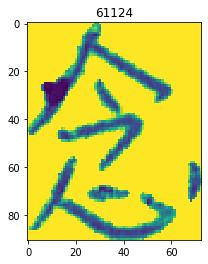

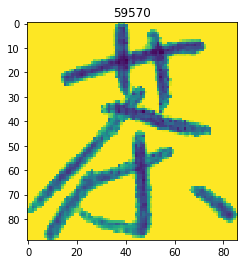

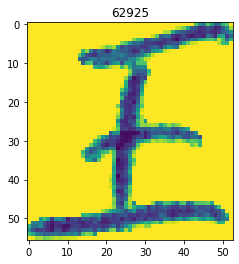

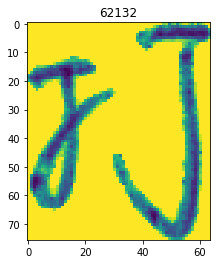

In [0]:
for image, label in data_train[:10]:
    plt.figure()
    plt.imshow(image)
    plt.title(label)

 Видно, что они разные по размеру

#Подготовим данные к обучению и создадим датасет

In [0]:
# np.unique([char for _, char in data])
# словари с уникальными лейблами для перевода их в id и обратно
char_to_id = {char:id for id, char in enumerate(np.unique([char for _, char in data_train]))}
id_to_char = {id:char for id, char in enumerate(np.unique([char for _, char in data_train]))}
val_size = 0.2  # доля данных для валидации


# генераторы для создания датасета 
def train_gen():


  for img, label in data_train[int(val_size*len(data_train)):]:
    img = img[:, :, np.newaxis]  # добавление размерности
    label = char_to_id[label]    # ван хот энкодинг
    yield img, label

def val_gen():


  for img, label in data_train[:int(val_size*len(data_train))]:
    img = img[:, :, np.newaxis]
    label = char_to_id[label]
    yield img, label

def test_gen():

  
    for img in data_test:
      img = img[:,:, np.newaxis]
      yield img

In [0]:
#датасеты для обучения
#обучающую выборку делим на train и val для валидации во время обучения
dataset_train = tf.data.Dataset.from_generator(train_gen,
                                               output_types=(tf.uint8, tf.int32),
                                               output_shapes=((None, None, 1), ()))

dataset_val = tf.data.Dataset.from_generator(val_gen,
                                               output_types=(tf.uint8, tf.int32),
                                               output_shapes=((None, None, 1), ()))

dataset_test = tf.data.Dataset.from_generator(test_gen,
                                               output_types=tf.float32,
                                               output_shapes=((None, None, 1)))

In [0]:
#функция для обработки картинок и леблов 
def process_train(img, label):


  img = tf.image.resize(img, (80,80))  # подгоняем картинки под одинаковый размер
  img = tf.cast(img, tf.float32)       # приводим к тф флоат типу
  #img = tf.image.per_image_standardization(img)
  img = (img - 127.5)/127.5            # нормализуем для более эффективного обучения и сходимости
  label = tf.one_hot(label, 1000)      # превращаем лейблы в ван-хот векторы
  return img, label


def process_test(img):


  img = tf.image.resize(img, (80,80))
  img = tf.cast(img, tf.float32)
  img = (img - 127.5)/127.5
  #img = tf.image.per_image_standardization(img)
  return img


# есть функция для аугментации, но она никак не помогла - качество только падало. Предполагаю, что аугментировать иероглифы - не лучшая идея, тк трансформация может потенциально изменить класс объекта
def augmentation(x, y):


    x = tf.image.adjust_contrast(x,2)
    x = tf.image.random_brightness(x, 0.2)
    #x = tf.image.adjust_hue(x, 0.2)
    x = tf.image.resize_with_crop_or_pad(
        x, 80 + 8, 80 + 8)
    x = tf.image.resize_image_with_pad(x, 80+6, 80+6)
    return x, y	

In [0]:
batch_size = 128 #64 задаем размер батча
dataset_train = dataset_train.map(process_train, num_parallel_calls=-1).shuffle(1024).prefetch(-1).batch(batch_size)
dataset_val = dataset_val.map(process_train, num_parallel_calls=-1).shuffle(1024).prefetch(-1).batch(batch_size)
dataset_test = dataset_test.map(process_test, num_parallel_calls=-1).prefetch(-1).batch(batch_size)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 # Создаем саму модель

Все использованные модели основаны просто на стэкинге сверточных слоев и макспулинга, также для контроля covariance shift добавлена батч нормализация + dropout для регуляризации и в качестве активации применен leaky relu или relu. Сам классификатор состоит из двух полносвязных слоев (264 или 1024) и слоя логитами с 1000 нейронами

 Первая модель выдала при сабмите качество около 0.97

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler

from tensorflow.keras import datasets, layers, models

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), input_shape=(80, 80, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1024))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dense(1000, activation='softmax'))

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(dataset_train, epochs=30, 
                    validation_data=dataset_val,
                    verbose=1)

Epoch 1/30
2082/2082 [==============================] - 399s 192ms/step - loss: 1.2732 - acc: 0.7504 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/30
2082/2082 [==============================] - 390s 187ms/step - loss: 0.2175 - acc: 0.9423 - val_loss: 0.1232 - val_acc: 0.9672
Epoch 3/30
2082/2082 [==============================] - 390s 187ms/step - loss: 0.1365 - acc: 0.9607 - val_loss: 0.0955 - val_acc: 0.9744
Epoch 4/30
2082/2082 [==============================] - 390s 187ms/step - loss: 0.1031 - acc: 0.9693 - val_loss: 0.0868 - val_acc: 0.9774
Epoch 5/30
2082/2082 [==============================] - 389s 187ms/step - loss: 0.0810 - acc: 0.9753 - val_loss: 0.0876 - val_acc: 0.9776
Epoch 6/30
2082/2082 [==============================] - 388s 186ms/step - loss: 0.0680 - acc: 0.9786 - val_loss: 0.0759 - val_acc: 0.9811
Epoch 7/30
2082/2082 [==============================] - 388s 186ms/step - loss: 0.0583 - acc: 0.9819 - val_loss: 0.0820 - val_acc: 0.9796
Epoch 8/30
2082/2082 [====

KeyboardInterrupt: ignored

Создаем файл с предсказанием:

In [0]:
submission = model.predict(dataset_test)
submission = submission.argmax(1)
predictions = np.array([id_to_char[i] for i in submission])
import pandas as pd
result = pd.read_csv("random_labels.csv")
result['Category'] = predictions
result.to_csv("submission11.csv", index=False)

Далее идут еще 2 модели

In [0]:
def make_model():

    """
    cnn model for image classification
    """
    
    model = models.Sequential()
    model.add(layers.Conv2D(filters=16, padding='same', kernel_size=(3,3), input_shape=(80,80,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.1))

    model.add(layers.Conv2D(filters=32, padding='same', kernel_size=(3,3))) 
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(filters=32, padding='same', kernel_size=(3,3))) 
    model.add(layers.BatchNormalization())  
    model.add(layers.LeakyReLU(0.1))

    model.add(layers.Conv2D(filters=64, padding='same', kernel_size=(3,3)))  
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same')) 

    model.add(layers.Conv2D(filters=64, padding='same', kernel_size=(3,3)))  
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same')) 

    model.add(layers.Conv2D(filters=128, padding='same', kernel_size=(3,3)))  
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same')) 

    model.add(layers.Dropout(0.25)) 
    model.add(layers.Flatten())
    model.add(layers.Dense(256))                
    model.add(layers.LeakyReLU(0.1))
    model.add(layers.Dropout(0.5))    
    model.add(layers.Dense(1000))             
    model.add(layers.Activation("softmax"))
    
    return model

In [0]:
tf.reset_default_graph()
model = make_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 16)        64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80, 80, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0

В качестве оптимизатора использован дефолтный адам. В ходе экспериментов применялись разные lr schedulers. Однако улучшения качества обучения они, к сожалению, не давали.

Обучается сеть с такими параметрами долго, зато особо не оверфитится.
Изначально кол-во эпох 100, но обучение было прервано на 78 эпохе, так как, возможно, модель начала немного оверфититься. Но это мы еще проверим на полном цикле обучения.

Итоговое качество сабмита >0.976

In [0]:
history = model.fit(dataset_train, epochs=100, 
                    validation_data=dataset_val,
                    verbose=1)

Epoch 1/100
4163/4163 [==============================] - 154s 37ms/step - loss: 1.8092 - acc: 0.6119 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/100
4163/4163 [==============================] - 138s 33ms/step - loss: 0.4636 - acc: 0.8750 - val_loss: 0.1501 - val_acc: 0.9597
Epoch 3/100
4163/4163 [==============================] - 138s 33ms/step - loss: 0.3249 - acc: 0.9086 - val_loss: 0.1147 - val_acc: 0.9685
Epoch 4/100
4163/4163 [==============================] - 138s 33ms/step - loss: 0.2623 - acc: 0.9250 - val_loss: 0.0951 - val_acc: 0.9742
Epoch 5/100
4163/4163 [==============================] - 137s 33ms/step - loss: 0.2243 - acc: 0.9345 - val_loss: 0.0844 - val_acc: 0.9779
Epoch 6/100
4163/4163 [==============================] - 138s 33ms/step - loss: 0.2002 - acc: 0.9400 - val_loss: 0.0759 - val_acc: 0.9793
Epoch 7/100
4163/4163 [==============================] - 138s 33ms/step - loss: 0.1782 - acc: 0.9470 - val_loss: 0.0778 - val_acc: 0.9800
Epoch 8/100
4163/4163 [===

KeyboardInterrupt: ignored

Создаем файл с предсказанием:

In [0]:
submission = model.predict(dataset_test)
submission = submission.argmax(1)
predictions = np.array([id_to_char[i] for i in submission])
import pandas as pd
result = pd.read_csv("random_labels.csv")
result['Category'] = predictions
result.to_csv("submission31.csv", index=False)

Далее та же модель была обучена 90 эпох - качество выросло практически до 0.98

In [0]:
#60 - 0.97689, 90 - 0.97897

In [0]:
#лучший результат 1 модель с бэтчнорм
tf.reset_default_graph()
model = make_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(dataset_train, epochs=60, 
                    validation_data=dataset_val,
                    verbose=1)

Epoch 1/60
2082/2082 [==============================] - 114s 55ms/step - loss: 2.0440 - acc: 0.5734 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/60
2082/2082 [==============================] - 106s 51ms/step - loss: 0.4762 - acc: 0.8727 - val_loss: 0.1659 - val_acc: 0.9560
Epoch 3/60
2082/2082 [==============================] - 106s 51ms/step - loss: 0.3215 - acc: 0.9085 - val_loss: 0.1131 - val_acc: 0.9695
Epoch 4/60
2082/2082 [==============================] - 102s 49ms/step - loss: 0.2565 - acc: 0.9254 - val_loss: 0.0905 - val_acc: 0.9755
Epoch 5/60
2082/2082 [==============================] - 102s 49ms/step - loss: 0.2150 - acc: 0.9373 - val_loss: 0.0865 - val_acc: 0.9770
Epoch 6/60
2082/2082 [==============================] - 102s 49ms/step - loss: 0.1870 - acc: 0.9438 - val_loss: 0.0700 - val_acc: 0.9816
Epoch 7/60
2082/2082 [==============================] - 101s 49ms/step - loss: 0.1690 - acc: 0.9492 - val_loss: 0.0694 - val_acc: 0.9814
Epoch 8/60
2082/2082 [===========

In [0]:
history = model.fit(dataset_train, epochs=30, 
                    validation_data=dataset_val,
                    verbose=1)

Epoch 1/30
2082/2082 [==============================] - 115s 55ms/step - loss: 0.0424 - acc: 0.9867 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/30
2082/2082 [==============================] - 107s 51ms/step - loss: 0.0422 - acc: 0.9865 - val_loss: 0.0466 - val_acc: 0.9911
Epoch 3/30
2082/2082 [==============================] - 104s 50ms/step - loss: 0.0404 - acc: 0.9868 - val_loss: 0.0498 - val_acc: 0.9899
Epoch 4/30
2082/2082 [==============================] - 109s 52ms/step - loss: 0.0424 - acc: 0.9868 - val_loss: 0.0436 - val_acc: 0.9914
Epoch 5/30
2082/2082 [==============================] - 106s 51ms/step - loss: 0.0422 - acc: 0.9867 - val_loss: 0.0434 - val_acc: 0.9920
Epoch 6/30
2082/2082 [==============================] - 104s 50ms/step - loss: 0.0401 - acc: 0.9874 - val_loss: 0.0442 - val_acc: 0.9917
Epoch 7/30
2082/2082 [==============================] - 107s 51ms/step - loss: 0.0406 - acc: 0.9872 - val_loss: 0.0515 - val_acc: 0.9899
Epoch 8/30
2082/2082 [===========

Получаем предсказание:

In [0]:
submission = model.predict(dataset_test)
submission = submission.argmax(1)
predictions = np.array([id_to_char[i] for i in submission])
import pandas as pd
result = pd.read_csv("random_labels.csv")
result['Category'] = predictions
result.to_csv("submission32.csv", index=False)

# Лучшая (соу фар) модель

In [0]:
#ЛУЧШАЯ МОДЕЛЬ (>0.98)

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), input_shape=(80, 80, 1)))  
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU(0.1)) 

model.add(layers.Conv2D(filters=64, padding='same', kernel_size=(3,3)))  
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU(0.1))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=128, padding='same', kernel_size=(3,3)))  
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU(0.1))

model.add(layers.Conv2D(filters=128, padding='same', kernel_size=(3,3)))  
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU(0.1))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same')) 

model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=256, padding='same', kernel_size=(3,3)))  
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU(0.1))

model.add(layers.Conv2D(filters=256, padding='same', kernel_size=(3,3)))  
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU(0.1))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))


model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=512, padding='same', kernel_size=(3,3)))  
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU(0.1))

model.add(layers.Conv2D(filters=512, padding='same', kernel_size=(3,3)))  
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU(0.1))
model.add(layers.MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1024)) 
model.add(layers.BatchNormalization())                
model.add(layers.LeakyReLU(0.1))
model.add(layers.Dropout(0.5))
 
model.add(layers.Dense(1000))             
model.add(layers.Activation("softmax"))
    

In [0]:
# 30 эпох, но обучение было прервано на 20 по личным обстоятельствам
tf.reset_default_graph()
#model = make_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
history = model.fit(dataset_train, epochs=30, 
                    validation_data=dataset_val,
                    verbose=1)

2082/2082 [==============================] - 309s 148ms/step - loss: 0.9536 - acc: 0.7987 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/30
Epoch 2/30
2082/2082 [==============================] - 294s 141ms/step - loss: 0.1867 - acc: 0.9493 - val_loss: 0.1149 - val_acc: 0.9681
Epoch 3/30
Epoch 3/30
2082/2082 [==============================] - 294s 141ms/step - loss: 0.1280 - acc: 0.9633 - val_loss: 0.0790 - val_acc: 0.9793
Epoch 4/30
Epoch 4/30
2082/2082 [==============================] - 294s 141ms/step - loss: 0.0946 - acc: 0.9721 - val_loss: 0.1237 - val_acc: 0.9657
Epoch 5/30
Epoch 5/30
2082/2082 [==============================] - 294s 141ms/step - loss: 0.0744 - acc: 0.9779 - val_loss: 0.0609 - val_acc: 0.9850
Epoch 6/30
Epoch 6/30
2082/2082 [==============================] - 295s 142ms/step - loss: 0.0609 - acc: 0.9814 - val_loss: 0.0632 - val_acc: 0.9851
Epoch 7/30
Epoch 7/30
2082/2082 [==============================] - 295s 142ms/step - loss: 0.0506 - acc: 0.9846 - val_lo

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [0]:
# +20 эпох
history = model.fit(dataset_train, epochs=20, 
                    validation_data=dataset_val,
                    verbose=1)

Epoch 1/20
2082/2082 [==============================] - 300s 144ms/step - loss: 0.0162 - acc: 0.9948 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/20
2082/2082 [==============================] - 294s 141ms/step - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0458 - val_acc: 0.9921
Epoch 3/20
2082/2082 [==============================] - 294s 141ms/step - loss: 0.0138 - acc: 0.9957 - val_loss: 0.0447 - val_acc: 0.9920
Epoch 4/20
2082/2082 [==============================] - 294s 141ms/step - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0453 - val_acc: 0.9915
Epoch 5/20
2082/2082 [==============================] - 294s 141ms/step - loss: 0.0126 - acc: 0.9959 - val_loss: 0.0452 - val_acc: 0.9922
Epoch 6/20
2082/2082 [==============================] - 294s 141ms/step - loss: 0.0122 - acc: 0.9961 - val_loss: 0.0440 - val_acc: 0.9922
Epoch 7/20
2082/2082 [==============================] - 294s 141ms/step - loss: 0.0115 - acc: 0.9963 - val_loss: 0.0459 - val_acc: 0.9924
Epoch 8/20
2082/2082 [====

Получаем предсказание:

In [0]:
submission = model.predict(dataset_test)
submission = submission.argmax(1)
predictions = np.array([id_to_char[i] for i in submission])
import pandas as pd
result = pd.read_csv("random_labels.csv")
result['Category'] = predictions
result.to_csv("submission34.csv", index=False)

Дальше решено было попробовать энсемблинг -
лучшие модели были сохранены)

In [0]:
model.save('cnn_model1.h5')

In [0]:
model.save('cnn_model2.h5')

In [0]:
model.save('cnn_model3.h5')

# Лучшее предсказание
получено с помощью энсемблинга. Предсказания 3 обученных здесь моделей были сложены и усреднены. Качество при сабмите: 0.985

In [0]:
import tensorflow as tf 
classifier1= tf.keras.models.load_model('cnn_model1.h5')
classifier2= tf.keras.models.load_model('cnn_model2.h5')
classifier3= tf.keras.models.load_model('cnn_model3.h5')


In [0]:
pred = (classifier1.predict(dataset_test) + classifier2.predict(dataset_test) + classifier3.predict(dataset_test))/3

In [0]:
pred = pred.argmax(1)
predictions = np.array([id_to_char[i] for i in pred])
import pandas as pd
result = pd.read_csv("random_labels.csv")
result['Category'] = predictions
result.to_csv("submission36(1).csv", index=False)